In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.linen.activation import softmax
from einops import rearrange
from jax import random
from jax.example_libraries import optimizers
import optax
import sys
import seaborn as sns

In [2]:
# MHSA attention layer
class Attention(nn.Module):

    scale_exp: jnp.float32
    dim: int
    heads: int
    
    def setup(self):
        
        self.c = 1.5 - self.scale_exp # exponent for the scale factor
        kif_qk = nn.initializers.normal(stddev = self.dim**(self.c - 0.5) ) # possibly needs to be scaled with N
        kif_v =  nn.initializers.normal(stddev = 1.0 ) # O_N(1) entries
        # computes key, query, value
        self.qk_layer = nn.Dense(features = 2 * self.heads * self.dim, kernel_init = kif_qk)
        self.v_layer = nn.Dense(features = self.heads * self.dim, kernel_init = kif_v)
        return
    
    def __call__(self,inputs):
        
        qk = self.qk_layer(inputs) / self.heads**(0.5) / self.dim**(self.c)
        qk = rearrange( qk, 'b l (h d) -> b h l d' , h = self.heads) # (batch, heads, loc, d )
        q,k = jnp.split(qk, 2, axis = -1) # gives q, k each of shape ( batch, heads, loc, d )
        v = self.v_layer(inputs) / jnp.sqrt( inputs.shape[-1] )
        v = rearrange(v, 'b l (h d) -> b h l d', h = self.heads)
        A = 1.0/ self.dim**(self.scale_exp) * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        phi_A = softmax( A, axis=-1 )
        out = jnp.einsum('ijkl,ijlm->ijkm', phi_A, v) # (batch, head, loc, d)  
        out = rearrange(out, 'b h l d -> b l (h d)')
        return out
    
class MLP_Block(nn.Module):

    features: int
    
    @nn.compact
    def __call__(self,x):
        N = self.features
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        h = nn.Dense(features = N, kernel_init = kif)(x) / jnp.sqrt(N)
        h = nn.relu(h)
        h = nn.Dense(features = N, kernel_init = kif)(h) / jnp.sqrt(N)
        return h


class PositionalEncoding(nn.Module):
    d_model : int         # Hidden dimensionality of the input.
    max_len : int  # Maximum length of a sequence to expect.
    
    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        self.pos_embedding = self.param('pos_embedding', 
                                        nn.initializers.normal(stddev=1.0), 
                                        (1, 1+self.max_len, self.d_model))

    def __call__(self, x, train=True):
        B,T,_ = x.shape
        x = x + self.pos_embedding[:,:T]
        return x

class VIT(nn.Module):
    """A simple VIT model"""
  
    dim: int
    heads: int
    depth: int
    patch_size: int
    scale_exp: jnp.float32
    adam_scale: int

    @nn.compact
    def __call__(self, x, train = True):
        N = self.heads * self.dim
        D = 3
        
        
        # patchify images
        x = rearrange(x, 'b (w p1) (h p2) c -> b (w h) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size) # (batch, loc, patch_ch_dim )
        
        kif_first= nn.initializers.normal(stddev = N**(-0.5*self.adam_scale) ) # O_N(1) entries
        kif0 = nn.initializers.normal(stddev = 0.0 )
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries

        x = N**(0.5 * self.adam_scale) * nn.Dense(features = N, kernel_init = kif_first)(x) / jnp.sqrt( 3 * self.patch_size**2 )
        x = x + PositionalEncoding(d_model = N, max_len = (32 // self.patch_size)**2 )
        #x = nn.relu(x)
        for l in range(self.depth):
            h = nn.LayerNorm()(x)
            x = x + 5.0/jnp.sqrt(depth) * Attention(dim = self.dim, scale_exp = self.scale_exp, heads = self.heads)(h)
            h = nn.LayerNorm()(x)
            x = x + 5.0/jnp.sqrt(depth) * MLP_Block(features = N)(h)
            
        # pool over location index
        x = x.mean(axis = 1) # (batch, N)
        x = nn.LayerNorm()(x)
        x = nn.Dense(features = 10, use_bias = False, kernel_init = kif0)(x) / N**(1.0-0.5*self.adam_scale)   # for mean field scaling
        return x
    

class simple_TF(nn.Module):
    
    # simple TF like model with
    # 1. 1/L scaling
    dim: int
    heads: int
    depth: int
    patch_size: int
    scale_exp: jnp.float32 = 1.0
    adam_scale: int = 0.0
    beta: jnp.float32 = 6.0
    
    @nn.compact
    def __call__(self, x, train = True):
        N = self.heads * self.dim
        L = self.depth
        D = 3
        
        # patchify images
        x = rearrange(x, 'b (w p1) (h p2) c -> b (w h) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size) # (batch, loc, patch_ch_dim )
        
        kif_first= nn.initializers.normal(stddev = N**(-0.5*self.adam_scale) * L**(0.5 * (1.0-self.adam_scale)) ) # O_N(1) entries
        kif = nn.initializers.normal( stddev = 1.0 ) # O_N(1) entries
        kif_last = nn.initializers.normal(stddev = L**(0.5 * (1-self.adam_scale) ) )
        
        x = L**(-0.5 * (1.0-self.adam_scale)) * N**(0.5 * self.adam_scale) * nn.Dense(features = N, kernel_init = kif_first)(x) / jnp.sqrt( D * self.patch_size**2 )
        #x = x + PositionalEncoding(d_model = N, max_len = (32 // self.patch_size)**2 )
        for l in range(self.depth):
            h = Attention(dim = self.dim, scale_exp = self.scale_exp, heads = self.heads)( nn.gelu(x) ) 
            h = nn.Dense(features = N, kernel_init = kif)( nn.gelu(h) ) / jnp.sqrt(N)
            x = x + self.beta / L * h
            
        # pool over location index
        x = x.mean(axis = 1) # (batch, N)
        #x = rearrange(x, 'b l d -> b (l d)')
        x = L**(-0.5*(1-self.adam_scale)) * nn.Dense(features = 10, use_bias = False, kernel_init = kif_last)(x) / N**(1.0-0.5*self.adam_scale)   # for mean field scaling
        return x

In [23]:
dim = 32
heads = 4
depth = 5
patch_size = 4
#model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0)
model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)

In [24]:
params = model.init(random.PRNGKey(0), jnp.ones((4,32,32,3)) ) 

out = model.apply(params, jnp.ones((4,32,32,3)))
print(out.shape)

(4, 10)


In [25]:
x = random.normal(random.PRNGKey(1), (15,32,32,3))
out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])

dict_keys(['Dense_0', 'Attention_0', 'Dense_1', 'Attention_1', 'Dense_2', 'Attention_2', 'Dense_3', 'Attention_3', 'Dense_4', 'Attention_4', 'Dense_5', 'Dense_6', '__call__'])
Dense_0
h mean 235.27
Dense_1
h mean 4.34
Dense_2
h mean 5.28
Dense_3
h mean 4.38
Dense_4
h mean 4.85
Dense_5
h mean 7.87
Dense_6
h mean 133.42


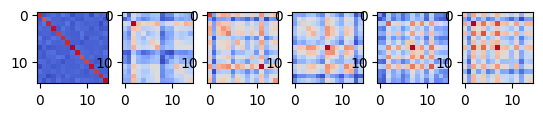

dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.42
0.005502549
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.44
0.005482058
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.44
0.00598872
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.46
0.007095895
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.48
0.007528662
(64, 64)


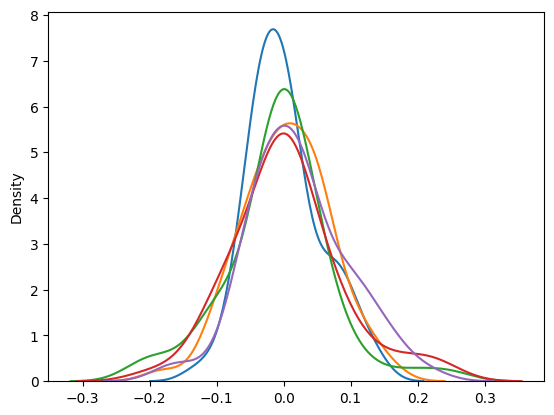

In [26]:
print(state['intermediates'].keys())

count = 0
for k in state['intermediates'].keys():
    if "Dense" in k:
        print(k)
        h = state['intermediates'][k]['__call__'][0]      
        print("h mean %0.2f" % jnp.mean(h**2))
        if len(h.shape) == 3:
            H = jnp.einsum('ijk,ljk->il', h, h) / ( h.shape[1] * h.shape[2] )
            plt.subplot(1, depth+1, count + 1)
            plt.imshow(H, cmap = 'coolwarm')
        count += 1
plt.show()

plt.figure()
count = 0
for k in state['intermediates'].keys():
    if "Attention" in k:
        print(state['intermediates'][k].keys())
        qk = state['intermediates'][k]['qk_layer']['__call__'][0] /  heads**(0.5) /  dim**(0.5)
        qk = rearrange( qk, 'b l (h d) -> b h l d' , h = heads) # (batch, heads, loc, d )
        q,k = jnp.split( qk, 2, axis = -1 ) # gives q, k each of shape ( batch, heads, loc, d )
        print("q shape:" + str(q.shape))
        print("q mean: %0.2f" % jnp.mean(q**2))
        A = 1.0 / dim * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        print(jnp.mean(A**2))
        #plt.subplot(2, depth + 1, count + 1)
        print(A[0,0].shape)
        #plt.imshow(A[0,0],cmap = 'coolwarm')
        count += 1
        sns.kdeplot(A[:,:,20,20].flatten())
plt.show()

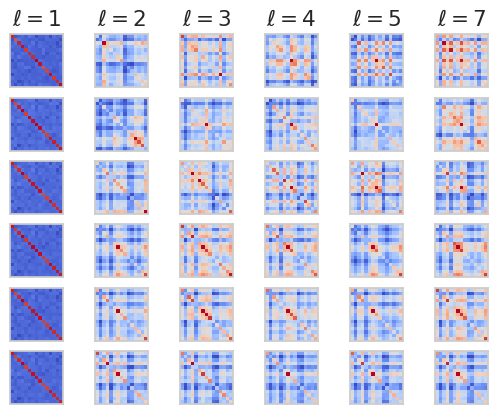

ValueError: num must be an integer with 1 <= num <= 36, not 37

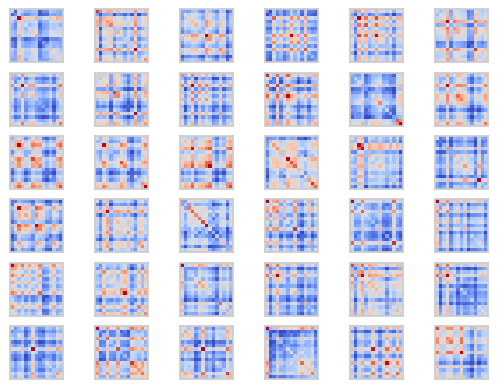

In [45]:
dim = 4
head_vals = [32,64,128,256,512,1024]
all_H = []

num_inits = 30

plt.figure()
count = 0
for i, heads in enumerate(head_vals):
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)
    
    Hi = []
    for j in range(num_inits):
        params = model.init(random.PRNGKey(j), jnp.ones((4,32,32,3)) ) 
        out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])
        Hij = []
        layer = 0
        for k in state['intermediates'].keys():
            if "Dense" in k:
                layer += 1
                h = state['intermediates'][k]['__call__'][0] / jnp.sqrt(dim*heads)       
                if len(h.shape) == 3:
                    H = jnp.einsum('ijk,ljk->il', h, h) / ( h.shape[1] * h.shape[2] )
                    if j == 0:
                        plt.subplot(len(head_vals), depth+1, count + 1)
                        plt.imshow(H, cmap = 'coolwarm')
                        plt.xticks([])
                        plt.yticks([])
                        count += 1

                    Hij += [H]
                    
                if j==0 and count == 0:
                    plt.ylabel(r'$\mathcal{H} = %d$' % heads)
                if i == 0:
                    plt.title(r'$\ell = %d$' % layer)
        Hi += [Hij]
        
    all_H += [ Hi ]
plt.show()


heads = 4
dims = [32,64,128,256,512,1024]
count = 0
all_H_vary_N = []
plt.figure()
for i, dim in enumerate(dims):
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)
    Hi = []
    for j in range(num_inits):
        params = model.init(random.PRNGKey(j), jnp.ones((4,32,32,3)) ) 
        out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])
        Hij = []
        for k in state['intermediates'].keys():
            if "Dense" in k and "0" not in k:
                h = state['intermediates'][k]['__call__'][0] / jnp.sqrt(dim*heads)        
                if len(h.shape) == 3:
                    H = jnp.einsum('ijk,ljk->il', h, h) / ( h.shape[1] * h.shape[2] )
                    plt.subplot(len(head_vals), depth+1, count + 1)
                    plt.imshow(H, cmap = 'coolwarm')
                    plt.xticks([])
                    plt.yticks([])
                    count += 1
                
                    Hij += [H]
        Hi += [Hij]
    all_H_vary_N += [Hi]
plt.show()
       

In [49]:
print(all_H_vary_N)

[]


(6, 30, 6, 15, 15)
(6, 6)


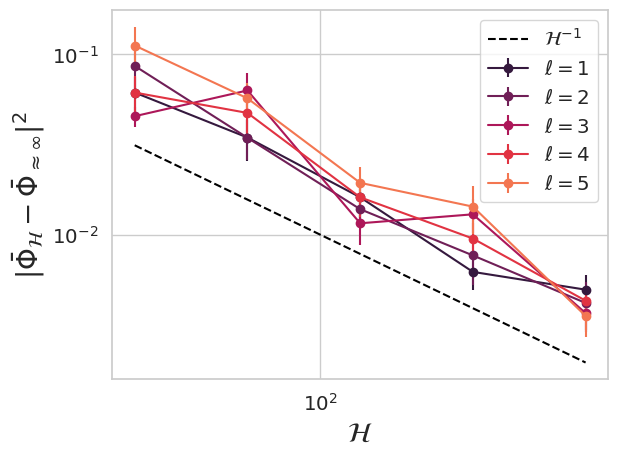

In [50]:
all_H = jnp.array(all_H)
print(all_H.shape) # head_vals x inits x layers x samples x samples

errs = jnp.mean( ( all_H - all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1)) / jnp.mean( (all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1))

std_devs = jnp.std( jnp.mean( ( all_H - all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (-2,-1)) / jnp.mean( (all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1)),  axis =1)

errs = errs.T
std_devs = std_devs.T

print(errs.shape)

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=len(errs))

for i, err in enumerate(errs[1:]):
    plt.errorbar( head_vals[:-1], err[:-1], std_devs[i+1,:-1] / jnp.sqrt( num_inits ), fmt = '-o', label = r'$\ell = %d$' % (i+1))

plt.plot(head_vals[:-1], jnp.array(head_vals[:-1], dtype = jnp.float32)**(-1.0), '--', color = 'black', label = r'$\mathcal{H}^{-1}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\mathcal{H}$',fontsize = 20)
plt.ylabel(r'$|\bar{\Phi}_{\mathcal{H}} - \bar{\Phi}_{\approx \infty}|^2$',fontsize = 20)
#plt.savefig('figures/bar_phi_init_convg.pdf')
plt.show()


In [3]:
data_dir = '/n/holyscratch01/pehlevan_lab/Everyone/cifar-5m-new'
file_name = f"{data_dir}/cifar5m_part{0}.npz"
part0 = np.load(file_name, allow_pickle=True)
X0, y0 = np.load(file_name, allow_pickle=True)

arr = [part0[k] for k in part0.keys()]
X = arr[0]
y = arr[1]
mean = X.mean()
std = X.std()
X = (X - mean) / std
print(y.shape)
print(X.shape)
print(X.dtype)

(1000448,)
(1000448, 32, 32, 3)
float64


(4, 4, 8, 8, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

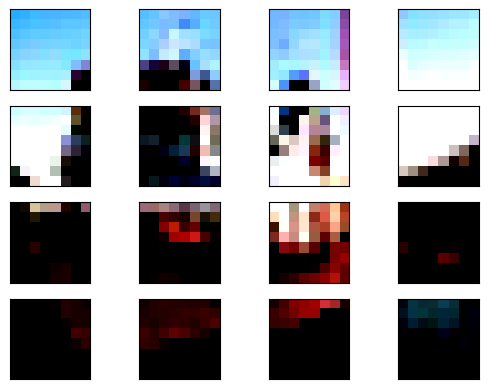

In [22]:
x_re = rearrange(X[0], '(a p1) (b p2) c -> a b p1 p2 c', p1 = 8, p2 = 8)
print(x_re.shape)

plt.figure()
for a in range(4):
    for b in range(4):
        plt.subplot(4,4,4*a+b+1)
        plt.imshow(x_re[a,b,:,:,:])
        plt.xticks([])
        plt.yticks([])
plt.show()

In [8]:
def get_intermediates_VIT_init(x, param_args, num_inits = 20):
    
    dim, heads, depth, patch_size, scale_exp = param_args
    count = 0
    
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)
    
    Hi = []
    Ai = []
    # loop over random seeds
    for j in range(num_inits):
        params = model.init(random.PRNGKey(j), jnp.ones((4,32,32,3)) ) 
        out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])
        Hij = []
        Aij = []
        layer = 0
        for k in state['intermediates'].keys():
            if "Dense" in k:
                layer += 1
                h = state['intermediates'][k]['__call__'][0] / jnp.sqrt( dim * heads )         
                if len(h.shape) == 3:
                    H = jnp.einsum('ijk,ljk->il', h, h) / ( h.shape[1] * h.shape[2] )
                    Hij += [H]
            if "Attention" in k:
                qk = state['intermediates'][k]['qk_layer']['__call__'][0] /  heads**(0.5) /  dim**(1.5 - scale_exp)
                qk = rearrange( qk, 'b l (h d) -> b h l d' , h = heads) # (batch, heads, loc, d )
                q,k = jnp.split( qk, 2, axis = -1 ) # gives q, k each of shape ( batch, heads, loc, d )
                A = 1.0 / dim**(scale_exp) * jnp.einsum('ijkl,ijml->ijkm', q, k)
                Aij += [A]
        
        Hi += [Hij]
        Ai += [Aij]
        
    return Hi, Ai

In [14]:
dim = 4
head_vals = [ 32,64,128,256,512, 1024 ]
patch_size = 4
depth = 4
scale_exp = 1.0
num_inits = 20

x = X[0:5] # take first 10 data points

all_H = []
all_A = []
for i, heads in enumerate(head_vals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    Hi, Ai = get_intermediates_VIT_init(x, param_args, num_inits = num_inits)
    all_H += [Hi]
    all_A += [Ai]

2024-05-01 15:32:48.065924: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.00MiB (rounded to 268435712)requested by op 
2024-05-01 15:32:48.066773: W external/tsl/tsl/framework/bfc_allocator.cc:494] ****************************************************************************************************
E0501 15:32:48.066880 1457312 pjrt_stream_executor_client.cc:2809] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 268435712 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:         0B
        maybe_live_out allocation:  128.00MiB
     preallocated temp allocation:  256.00MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  384.00MiB
              total fragmentation:       240B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 128.00MiB
		Operator: op_name="j

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 268435712 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:         0B
        maybe_live_out allocation:  128.00MiB
     preallocated temp allocation:  256.00MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  384.00MiB
              total fragmentation:       240B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 128.00MiB
		Operator: op_name="jit(_normal)/jit(main)/jit(_normal_real)/mul" source_file="/tmp/ipykernel_1457312/3274728273.py" source_line=21
		XLA Label: fusion
		Shape: f32[4096,8192]
		==========================

	Buffer 2:
		Size: 64.00MiB
		Operator: op_name="jit(_normal)/jit(main)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_1457312/3274728273.py" source_line=21
		XLA Label: fusion
		Shape: u32[16777216]
		==========================

	Buffer 3:
		Size: 64.00MiB
		Operator: op_name="jit(_normal)/jit(main)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_1457312/3274728273.py" source_line=21
		XLA Label: fusion
		Shape: u32[16777216]
		==========================

	Buffer 4:
		Size: 64.00MiB
		Operator: op_name="jit(_normal)/jit(main)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_1457312/3274728273.py" source_line=21
		XLA Label: fusion
		Shape: u32[16777216]
		==========================

	Buffer 5:
		Size: 64.00MiB
		Operator: op_name="jit(_normal)/jit(main)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_1457312/3274728273.py" source_line=21
		XLA Label: fusion
		Shape: u32[16777216]
		==========================

	Buffer 6:
		Size: 16B
		Operator: op_name="jit(_normal)/jit(main)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_1457312/3274728273.py" source_line=21
		XLA Label: fusion
		Shape: (u32[16777216], u32[16777216])
		==========================

	Buffer 7:
		Size: 16B
		Operator: op_name="jit(_normal)/jit(main)/jit(_normal_real)/jit(_uniform)/threefry2x32" source_file="/tmp/ipykernel_1457312/3274728273.py" source_line=21
		XLA Label: fusion
		Shape: (u32[16777216], u32[16777216])
		==========================

	Buffer 8:
		Size: 8B
		Entry Parameter Subshape: u32[2]
		==========================



In [ ]:
all_H = jnp.array(all_H) # dims x inits x layer x batch x batch
#all_A = jnp.array(all_A) # dims x inits x layer x batch x loc x loc

In [ ]:
errs = jnp.mean( ( all_H - all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1)) / jnp.mean( (all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1))
std_devs = jnp.std( jnp.mean( ( all_H - all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (-2,-1)) / jnp.mean( (all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1)),  axis =1)

errs = errs.T
std_devs = std_devs.T

print(errs.shape)
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=len(errs))

for i, err in enumerate(errs[1:]):
    plt.errorbar( head_vals[:-1], err[:-1], std_devs[i+1,:-1] / jnp.sqrt( num_inits ), fmt = '-o', label = r'$\ell = %d$' % (i+1))

plt.plot(head_vals[:-1], jnp.array(head_vals[:-1], dtype = jnp.float32)**(-1.0), '--', color = 'black', label = r'$\mathcal{H}^{-1}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\mathcal{H}$',fontsize = 20)
plt.ylabel(r'$|\bar{\Phi}_{\mathcal{H}} - \bar{\Phi}_{\mathcal{H} \approx \infty}|^2$',fontsize = 20)
#plt.savefig('figures/bar_phi_init_convg.pdf')
plt.show()

## Train VIT on CIFAR-5M

In [ ]:
def get_data(dset_count):
    
    data_dir = '/n/holyscratch01/pehlevan_lab/Everyone/cifar-5m-new'
    file_name = f"{data_dir}/cifar5m_part{dset_count}.npz"
    part0 = np.load(file_name, allow_pickle=True)

    arr = [part0[k] for k in part0.keys()]
    X = arr[0]
    y = arr[1]
    mean = X.mean()
    std = X.std()
    X = (X - mean) / std
    return X, y

def train_model(param_args, opt_args, data = None, adam = False, seed = 0):

    dim, heads, depth, patch_size, scale_exp = param_args
    T, batch, gamma, lr = opt_args
    
    if adam:
        adam_scale = 1.0
        opt_init, opt_update, get_params = optimizers.adam( lr / jnp.sqrt(heads * dim) , eps = 1e-20)

    else:
        adam_scale = 0.0
        opt_init, opt_update, get_params = optimizers.sgd( depth * heads * dim * gamma**2 *  lr)

    #model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = scale_exp, adam_scale = adam_scale)
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = scale_exp, adam_scale = adam_scale)
    params = model.init(random.PRNGKey(seed), jnp.ones((4,32,32,3)) )['params']
                                                               
    opt_state = opt_init(params)

    shift_fn = jax.jit(lambda p, x: (model.apply({'params':p}, x) - model.apply({'params':params}, x)) / gamma)
    #shift_fn = jax.jit(lambda p, x: model.apply({'params':p}, x) / gamma)
    loss_fn = jax.jit(lambda params, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits=shift_fn(params, Xb), labels=yb).mean())
    grad_fn = jax.jit(jax.grad(loss_fn))


    losses = []
    
    loss_t = 0.0
    dset_count = 0
    
    if data != None:
        X,y = data
    
    for t in range(T):
    
        if data == None:
            if t == 0:
                X, y = get_data(dset_count)
                ind = 0
            elif ind+batch >= X.shape[0]:
            
                if dset_count < 4:
                    dset_count += 1
                    X, y = get_data(dset_count)
                    ind = 0
                else:
                    return losses
        else:
            ind = (t*batch) % X.shape[0]
        Xt = X[ind:ind+batch]
        yt = y[ind:ind+batch]
        ind += batch
        
        #loss_t = loss_t * t/(t+1) + 1.0/(t+1) * loss_fn(get_params(opt_state), Xt, yt)
        loss_t = loss_fn(get_params(opt_state), Xt, yt)
        losses += [loss_t]
        if t % 10 == 0:
            sys.stdout.write(f'\r loss = {loss_t}')
        opt_state = opt_update(t,grad_fn(get_params(opt_state), Xt, yt),opt_state)
        
    return losses

### Convergence Experiments

Things to show

1. Predictions $f$ converge as $H \to \infty$
2. Distribution over attention $A$ converges

In [ ]:
dimvals = [4, 8, 16, 32, 64]
depth = 2
heads = 8
patch_size = 4
scale_exp = 1.0

T = 10000
lr = 0.01
gamma = 0.5
batch = 128

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args, (X, y))
    all_losses += [losses] 

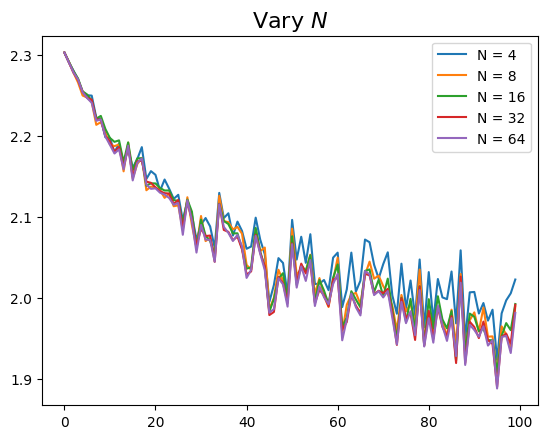

In [89]:
for i, loss in enumerate(all_losses):
    plt.plot(loss[0:100], label = f'N = {dimvals[i]}')
plt.legend()
#plt.ylim([0,2.5])
plt.title(r'Vary $N$',fontsize = 16)
plt.show()

In [78]:
dim = 4
depth = 2
head_vals = [16, 32, 64, 128, 256, 512]
patch_size = 4
scale_exp = 1.0

T = 250
lr = 0.01
gamma = 0.5
batch = 256

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, heads in enumerate(head_vals):
    
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"G = {heads}")
    losses = train_model(param_args, opt_args, (X, y))
    all_losses += [losses] 

 
G = 4
 loss = 1.7633390426635742 
G = 8
 loss = 1.7091329097747803 
G = 16
 loss = 1.6895899772644043 
G = 32
 loss = 1.6761701107025146 
G = 64
 loss = 1.6627938747406006 
G = 128
 loss = 1.6557877063751224

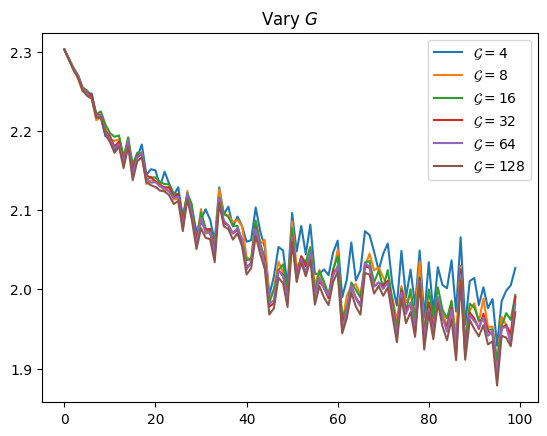

In [83]:
for i, loss in enumerate(all_losses):
    plt.plot(loss[0:100], label = r'$\mathcal{G} = %d$' % head_vals[i])
plt.legend()
plt.title(r'Vary $G$')
plt.show()

In [84]:
depths = [2,4,8,16,32]
dim = 8
depth = 2
heads = 16
patch_size = 4
scale_exp = 1.0

T = 2000
lr = 0.01
gamma = 0.5
batch = 256

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, depth in enumerate(depths):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"L = {depth}")
    losses = train_model(param_args, opt_args, (X, y))
    all_losses += [losses] 

 
L = 2
 loss = 1.5068228244781494 
L = 4
 loss = 1.5097254514694214 
L = 8
 loss = 1.5188524723052979 
L = 16
 loss = 1.5124251842498784 
L = 32
 loss = 1.5298936367034912

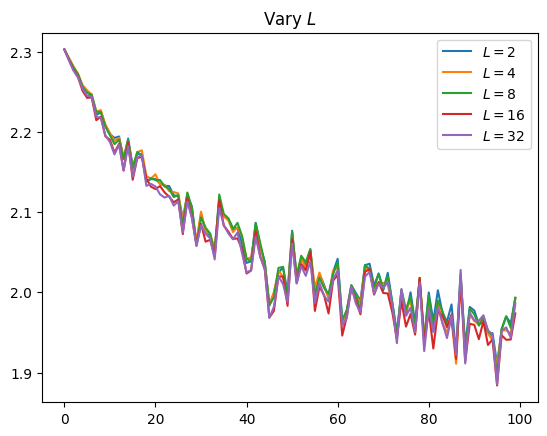

In [87]:
for i, loss in enumerate(all_losses):
    plt.plot(loss[0:100], label = r'$L = %d$' % depths[i])
plt.legend()
plt.title(r'Vary $L$')
plt.show()

In [61]:
dimvals = [4, 8, 16, 32, 64]
depth = 2
heads = 3
patch_size = 4
scale_exp = 0.5

T = 1000

lr = 0.1
gamma = 0.75
batch = 64

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args)
    all_losses += [losses] 

 
dim = 4
 loss = 1.9258025884628296 
dim = 8
 loss = 1.8374379873275757 
dim = 16
 loss = 1.8021626472473145 
dim = 32
 loss = 1.7546936273574836 
dim = 64
 loss = 1.7541667222976685

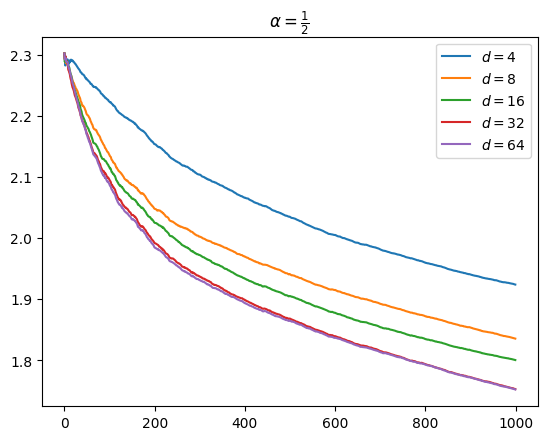

In [63]:
for i, loss in enumerate(all_losses):
    plt.plot(loss, label = r'$d = %d$' % dimvals[i])
plt.legend()
plt.title(r'$\alpha = \frac{1}{2}$')
plt.show()

## LR Transfer

In [12]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 1.0

T = 1000
gamma = 1.0
batch = 128

lrs = jnp.logspace(-1.5, 0.6, 6)

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses += [losses_i] 
    
    

 
dim = 4
 loss = nan893662452697754 
dim = 8
 loss = nan .1303710937555
dim = 16
 loss = nan3.6650390625873 
dim = 32
 loss = nan739264011383057

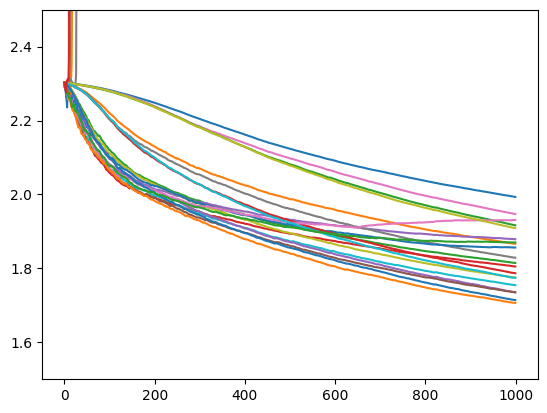

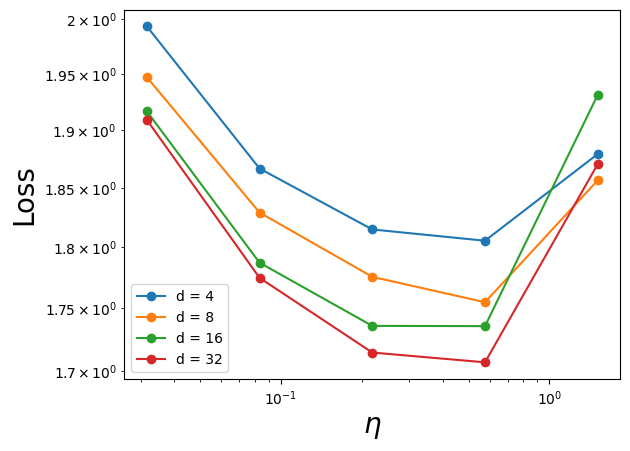

In [13]:
final_losses = []
for loss in all_losses:
    final_i = []
    for loss_eta in loss:
        plt.plot(loss_eta)
        final_i += [loss_eta[-1]]
    final_losses += [final_i]
plt.ylim([1.5,2.5])
plt.show()


for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.show()

In [14]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 0.5

T = 1000
gamma = 1.0
batch = 128

lrs = jnp.logspace(-1.5, 0.6, 6)

all_losses_half = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses_half += [losses_i] 
    
    

 
dim = 4
 loss = nan865818023681644 
dim = 8
 loss = nan5.5703125066406 
dim = 16
 loss = nan2669056.0146973 
dim = 32
 loss = nan934746742248535

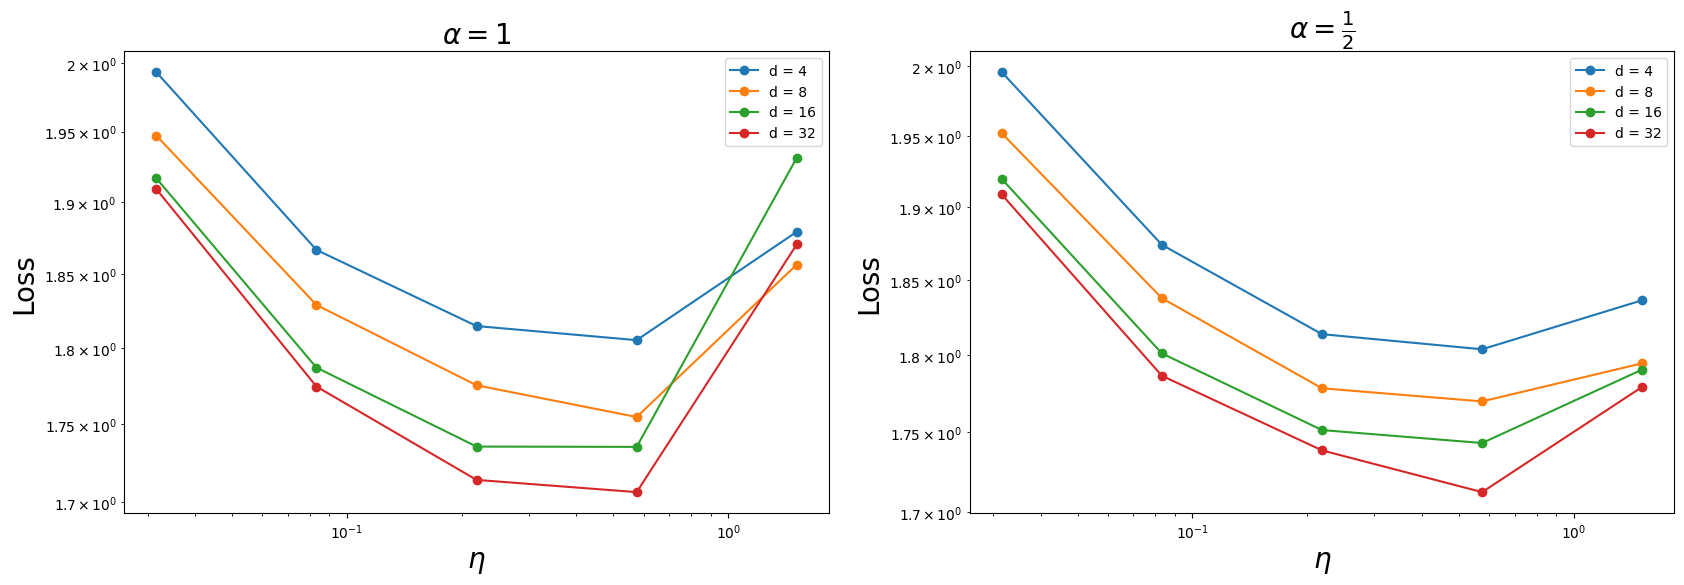

In [23]:
final_half= []
for i,loss in enumerate(all_losses_half):
    final_i = []
    for loss_eta in loss:
         
        final_i += [loss_eta[-1]]
    final_half += [final_i]
 


plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title(r'$\alpha = 1$',fontsize = 20)

plt.subplot(1,2,2)
for i,loss in enumerate(final_half):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title(r'$\alpha = \frac{1}{2}$',fontsize = 20)

plt.show()

In [81]:
dim = 16
depth = 6
head_vals = [2,4,8,16]
patch_size = 4
scale_exp = 1.0

T = 2500
gamma = 1.0
batch = 64

lrs = jnp.logspace(-2.5, 0.0, 6)

all_losses = []
for i, heads in enumerate(head_vals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses += [losses_i] 
    
    

 
dim = 16
 loss = 1.9536570310592651 
dim = 16
 loss = 1.869832992553711 
dim = 16
 loss = 1.8842977285385132 
dim = 16
 loss = 1.8765273094177246

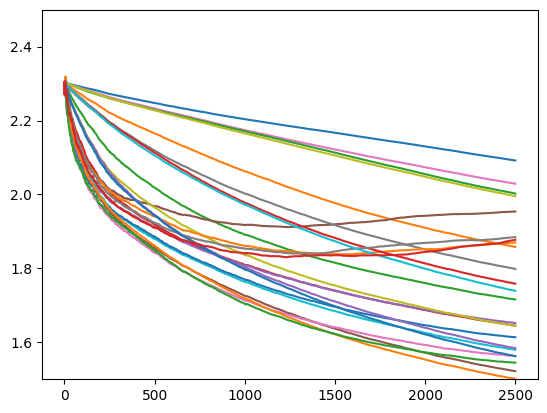

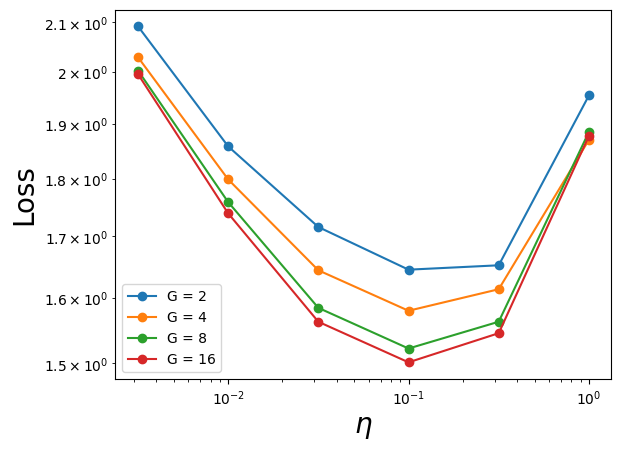

In [82]:
final_losses = []
for loss in all_losses:
    final_i = []
    for loss_eta in loss:
        plt.plot(loss_eta)
        final_i += [loss_eta[-1]]
    final_losses += [final_i]
plt.ylim([1.5,2.5])
plt.show()


for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'G = {head_vals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.show()

# Implement ADAM

In [6]:

dimvals = [4, 8, 16, 32, 64]
depth = 4
heads = 4
patch_size = 4
scale_exp = 1.0

T = 2000
lr = 0.1
gamma = 0.8
batch = 64

opt_args = ( T, batch, gamma, lr )
all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args, (X, y), adam = True)
    all_losses += [losses] 

 
dim = 4
 loss = 1.5709433555603027 
dim = 8
 loss = 1.5087578296661377 
dim = 16
 loss = 1.4715726375579834 
dim = 32
 loss = 1.4491610527038574 
dim = 64
 loss = 1.4471646547317505

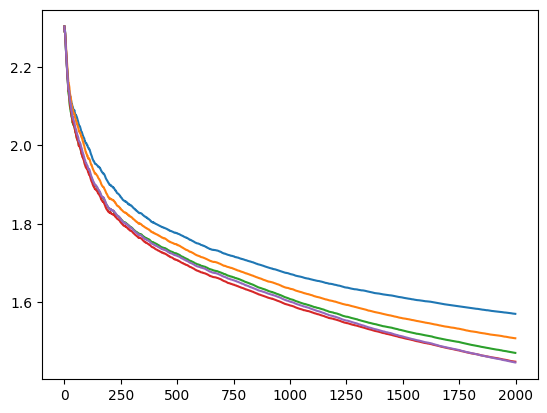

In [7]:
for loss in all_losses:
    plt.plot(loss)
plt.show()

In [1]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 1.0

T = 1000
gamma = 1.0
batch = 64

lrs = jnp.logspace(-3.0, 0.6, 7)

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y), adam = True)]        
    all_losses += [losses_i] 

NameError: name 'jnp' is not defined

ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

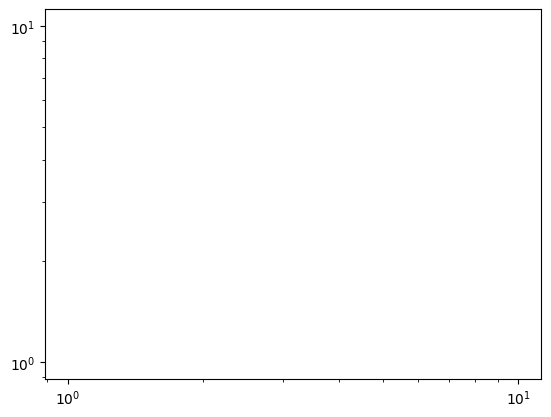

In [122]:

for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title('HP Transfer Adam',fontsize = 20)
plt.tight_layout()
plt.show()

## Load Saved Results

In [1]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:

class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 2500
    arch = 'vit'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 2
    width = 16
    beta = 4.0
    gamma_zero = 0.1
    heads = 4
    

args = Args()


def get_run_name(args):
    return "model_{}/dataset_{}/lr_{:.4f}/mom_{:.2f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.arch, args.dataset, args.lr, args.mom, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)


save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/cifar_VIT'


## Head sweep 
lrs = np.logspace(-2.5,1.0,12)
heads = [4,8,16,32,64, 128]

all_losses = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    


all_losses_half = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        args.scale_exp = 0.5
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses_half += [loss_i]


In [39]:
final_losses =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses ] 
final_losses_half =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses_half ] 

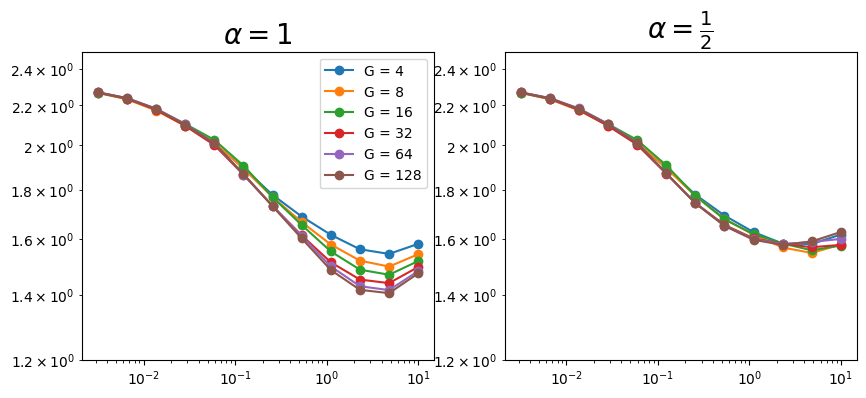

In [40]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)

for i,final_i in enumerate(final_losses):
    plt.loglog(lrs, np.array(final_i), '-o', label = f'G = {heads[i]}')
plt.ylim([1.2,2.5])
plt.legend()
plt.title(r'$\alpha = 1$',fontsize = 20)
plt.subplot(1,2,2)
plt.title(r'$\alpha = \frac{1}{2}$',fontsize = 20)
for final_i in final_losses_half:
    plt.loglog(lrs, np.array(final_i), '-o')
plt.ylim([1.2,2.5])
plt.show()

In [3]:

class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 20000
    arch = 'vit'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 2
    width = 32
    beta = 4.0
    gamma_zero = 0.1
    heads = 4
    

args = Args()



## Head sweep 
lrs = np.logspace(-2.5,1.0,12)
heads = [4,8,16,32,64]

all_losses = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    


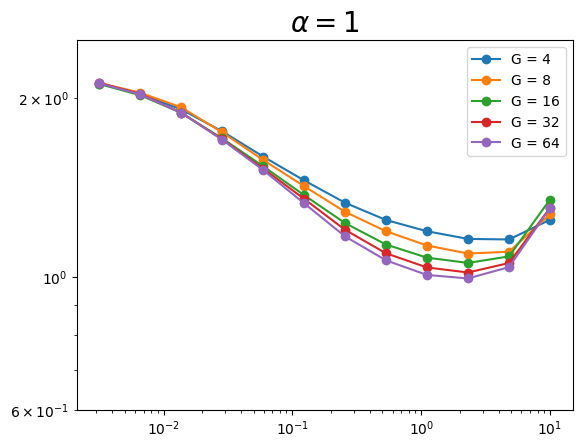

In [4]:
final_losses =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses ] 

for i,final_i in enumerate(final_losses):
    plt.loglog(lrs, np.array(final_i), '-o', label = f'G = {heads[i]}')
plt.ylim([0.6,2.5])
plt.legend()
plt.title(r'$\alpha = 1$',fontsize = 20)
plt.show()